run metrics only on top 30 industries instead of the full thing because if the data has a lot of 1 and 0 it is likely that there is no significant difference

In [33]:
# import dependencies 
import pandas as pd
from scipy.stats import levene, bartlett, ttest_ind
from collections import Counter

## Tests

**`levene`**
Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

In [2]:
# manual input based on headquarters region filter
regions = ['US', 'EU', 'Europe', 'China']
by_industry_group = ['industry_groups', 'industries']

### Run Significance Tests + Export Results
compare gender difference within region

**updated metric**: the updated metric only takes the top 30% of the industries because or else the industry list of numbers have a lot of 0 and 1 which affect the calculated standard deviation 

In [31]:
def test_diff(n, data='female-led', test='levene'):
    '''
    compare within region
    n: top n industries
    '''

    df_metrics = pd.DataFrame()
    df_metrics['region'] = regions

    by_industry_group = ['industry_groups', 'industries']

    for big in by_industry_group:

            # initiate containers
            female_co_std_data = []
            not_female_co_std_data = []

            # significance test
            stat_data = []
            p_data = []

            for region in regions:
                
                ### which df to use?
                
                # raw counts
                if data == 'raw':
                    df = pd.read_csv(f'../data/crunchbase-aggregated/{region}-{big}.csv')
                
                # count from equal number of female and male companies
                elif data == 'equal':
                    df = pd.read_csv(f'../data/crunchbase-aggregated/{region}-{big}_equal.csv')
                
                # equal & define female companies as female founders >50%
                elif data == 'female-led':
                    df = pd.read_csv(f'../data/crunchbase-aggregated/{region}-{big}_updated.csv')
                
                
                ### updated metric
                # extract info
                top_n_female = list(df.sort_values(by=['#female_co'], ascending=False)[:n]['industry'])
                top_n_not_female = list(df.sort_values(by=['#not_female_co'], ascending=False)[:n]['industry'])
                top30 = list(set(top_n_female).union(set(top_n_not_female)))
                df = df.set_index('industry').loc[top30].reset_index()
                
                # female
                female_co_std = df['#female_co'].std()
                female_co_std_data.append(female_co_std)

                # not female
                not_female_co_std = df['#not_female_co'].std()
                not_female_co_std_data.append(not_female_co_std)

                # significance test                
                if test=='bartlett':
                    stat, p = bartlett(df['#female_co'].dropna(), df['#not_female_co'].dropna())
                elif test=='ttest':
                    stat, p = ttest_ind(df['#female_co'].dropna(), df['#not_female_co'].dropna())
                else:
                    stat, p = levene(df['#female_co'].dropna(), df['#not_female_co'].dropna(), center='mean')
                
                stat_data.append(stat)
                p_data.append(p)


            # add data to df
            if (big=='industries'):
                df_metrics[f'#female_co_std_{n}'] = female_co_std_data
                df_metrics[f'#not_female_co_std_{n}'] = not_female_co_std_data
                df_metrics[f'{test}_stat_{n}'] = stat_data
                df_metrics[f'{test}_p_{n}'] = p_data

            elif (big=='industry_groups'):
                df_metrics[f'#female_co_std_group_{n}'] = female_co_std_data
                df_metrics[f'#not_female_co_std_group_{n}'] = not_female_co_std_data
                df_metrics[f'{test}_stat_group_{n}'] = stat_data
                df_metrics[f'{test}_p_group_{n}'] = p_data
    
    return df_metrics

In [27]:
def present_test_diff(df_metrics, axis=0):
    p_cols  = [col for col in df_metrics.columns if '_p' in col]
    df_p = df_metrics[['region']+p_cols]
    return df_p.style.background_gradient(cmap='Blues', axis=axis)

In [13]:
# this is biased because there is more male than female companies being compared
present_test_diff(test_diff(30, data='raw'))

,region,levene_p_group_30,levene_p_30
0,US,0.000139,0.000150
1,EU,0.000042,0.000103
2,Europe,0.000011,0.000062
3,China,0.000000,0.000000


In [14]:
# this is not significant because female companies was defined as with at least one female founder
present_test_diff(test_diff(30, data='equal'))

,region,levene_p_group_30,levene_p_30
0,US,0.889289,0.711359
1,EU,0.990386,0.493506
2,Europe,0.684584,0.466729
3,China,0.099870,0.034663


In [18]:
# this resolves the raw problem using same number of companies
# this also refines female-led definition to 50%
present_test_diff(test_diff(30, data='female-led'))

,region,levene_p_group_30,levene_p_30
0,US,0.326481,0.181325
1,EU,0.349270,0.839001
2,Europe,0.915356,0.618978
3,China,0.415862,0.009549


In [30]:
present_test_diff(test_diff(30, data='female-led', test='bartlett'))

,region,bartlett_p_group_30,bartlett_p_30
0,US,0.252750,0.144609
1,EU,0.434897,0.831425
2,Europe,0.842070,0.547995
3,China,0.552441,0.001305


In [55]:
def plot_top_df(region, big, n):
    '''
    compare within region
    n: top n industries
    '''

    df = pd.read_csv(f'../data/crunchbase-aggregated/{region}-{big}.csv')

    top_n_female = list(df.sort_values(by=['#female_co'], ascending=False)[:n]['industry'])
    top_n_not_female = list(df.sort_values(by=['#not_female_co'], ascending=False)[:n]['industry'])
    top30 = list(set(top_n_female).union(set(top_n_not_female)))
    top_df = df.set_index('industry').loc[top30].reset_index()
                   
    top_df[['industry', '#female_co', '#not_female_co']]\
    .set_index('industry')\
    .plot.bar(figsize=(15,6),
              subplots=True,
              title=f'{region}-{big}-{n}');

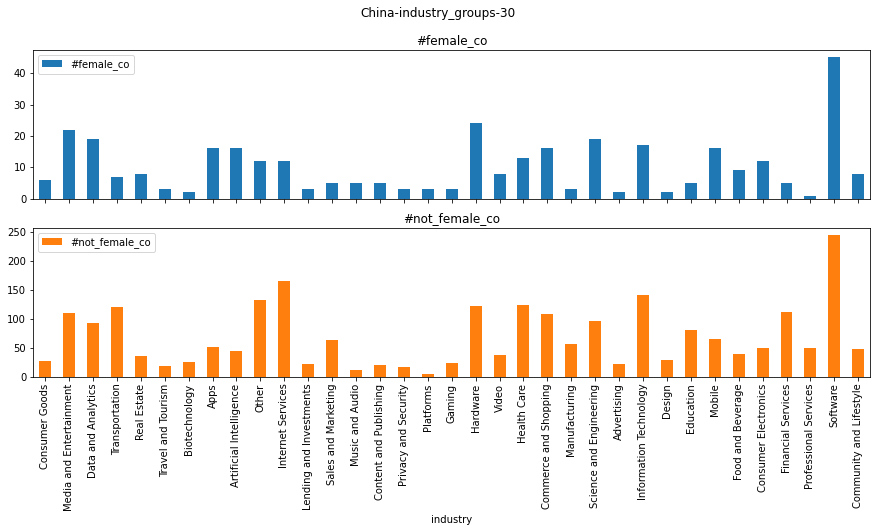

In [56]:
plot_top_df('China', 'industry_groups', 30)

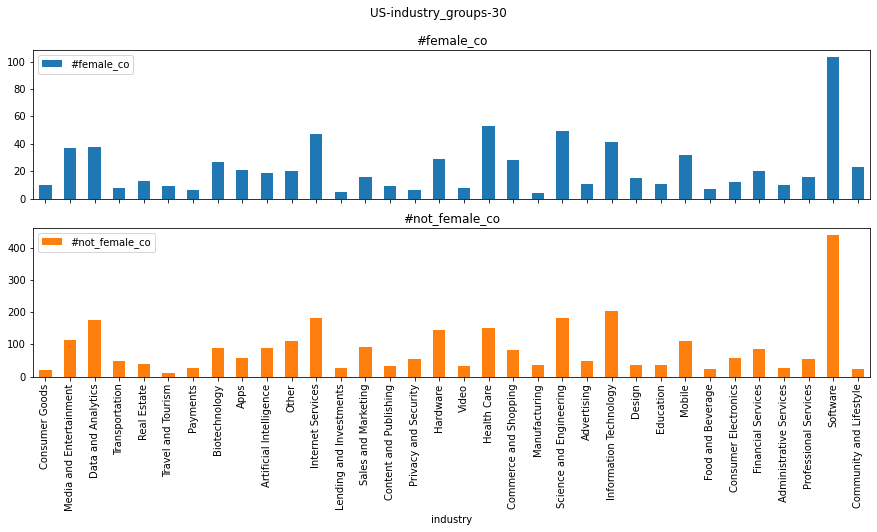

In [57]:
plot_top_df('US', 'industry_groups', 30)

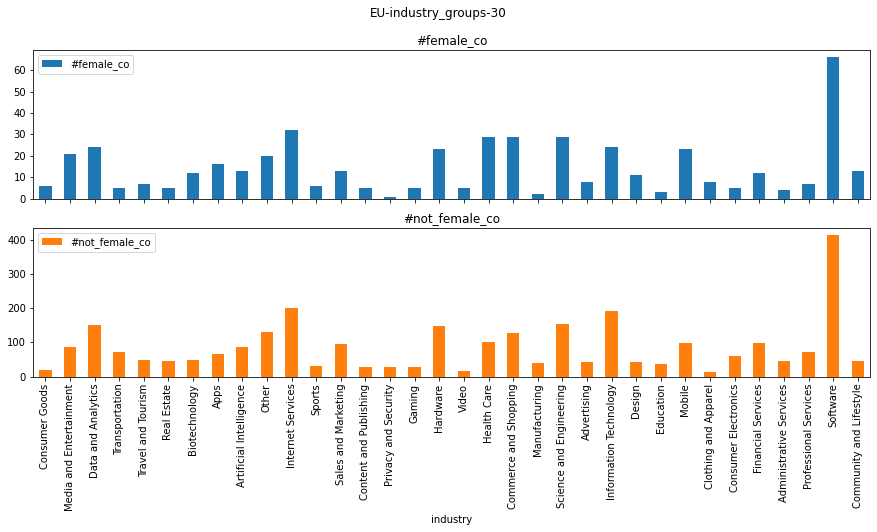

In [58]:
plot_top_df('EU', 'industry_groups', 30)

### Run Significance Tests + Export Results
compare industry difference across regions

In [6]:
def test_diff_region(n=''):
    '''compare between regions'''

    df_metrics = pd.DataFrame()
#     regions = ['US', 'EU', 'Europe', 'China']
    region_pair_data = [['US', 'EU'], ['US', 'Europe'], ['US', 'China'],
                        ['EU', 'Europe'], ['EU', 'China'], ['Europe', 'China']]

    by_industry_group = ['industry_groups', 'industries']

    for big in by_industry_group:
        
#         region_pair_data = []

        # significance test
        levene_stat_female_data = []
        levene_p_female_data = []
        levene_stat_all_data = []
        levene_p_all_data = []
        
        for region_pair in region_pair_data:
            
            region1 = region_pair[0]
            region2 = region_pair[1]

            if isinstance(n, int):
                df1 = pd.read_csv(f'../data/crunchbase-aggregated/{region1}-{n}-{big}.csv')
                df2 = pd.read_csv(f'../data/crunchbase-aggregated/{region2}-{n}-{big}.csv')

            else:
                df1 = pd.read_csv(f'../data/crunchbase-aggregated/{region1}-{big}_updated.csv')
                df2 = pd.read_csv(f'../data/crunchbase-aggregated/{region2}-{big}_updated.csv')
#                         df1 = pd.read_csv(f'../data/crunchbase-aggregated/{region1}-{big}_equal.csv')
#                         df2 = pd.read_csv(f'../data/crunchbase-aggregated/{region2}-{big}_equal.csv')

            # combined
            df1['#all_co'] = df1['#female_co'] + df1['#not_female_co']
            df2['#all_co'] = df2['#female_co'] + df2['#not_female_co']

            # significance test
            stat1, p1 = levene(df1['#female_co'].dropna(), df2['#female_co'].dropna())
            levene_stat_female_data.append(stat1)
            levene_p_female_data.append(p1)

            stat2, p2 = levene(df1['#all_co'].dropna(), df2['#all_co'].dropna())
            levene_stat_all_data.append(stat2)
            levene_p_all_data.append(p2)


        # add data to df
        if (big=='industries'):
            df_metrics[f'levene_stat_f{n}'] = levene_stat_female_data
            df_metrics[f'levene_p_f{n}'] = levene_p_female_data
            df_metrics[f'levene_stat_all{n}'] = levene_stat_all_data
            df_metrics[f'levene_p_all{n}'] = levene_p_all_data

        elif (big=='industry_groups'):
            df_metrics[f'levene_stat_group_f{n}'] = levene_stat_female_data
            df_metrics[f'levene_p_group_f{n}'] = levene_p_female_data
            df_metrics[f'levene_stat_group_all{n}'] = levene_stat_all_data
            df_metrics[f'levene_p_group_all{n}'] = levene_p_all_data

    df_metrics['region'] = region_pair_data
    return df_metrics

In [83]:
present_test_diff(test_diff_region(98))

,region,levene_p_group_f98,levene_p_group_all98,levene_p_f98,levene_p_all98
0,"['US', 'EU']",0.735366,0.877441,0.631559,0.817958
1,"['US', 'Europe']",0.543414,0.992644,0.357452,0.821754
2,"['US', 'China']",0.938270,0.668532,0.697657,0.520438
3,"['EU', 'US']",0.735366,0.877441,0.631559,0.817958
4,"['EU', 'Europe']",0.812232,0.866564,0.628524,0.995705
5,"['EU', 'China']",0.787677,0.793488,0.949908,0.638621
6,"['Europe', 'US']",0.543414,0.992644,0.357452,0.821754
7,"['Europe', 'EU']",0.812232,0.866564,0.628524,0.995705
8,"['Europe', 'China']",0.583470,0.646357,0.590276,0.637670
9,"['China', 'US']",0.938270,0.668532,0.697657,0.520438


In [84]:
present_test_diff(test_diff_region(32))

,region,levene_p_group_f32,levene_p_group_all32,levene_p_f32,levene_p_all32
0,"['US', 'EU']",0.499817,0.448983,0.851834,0.931535
1,"['US', 'Europe']",0.444848,0.451643,0.109068,0.214902
2,"['US', 'China']",0.905310,0.163014,0.938730,0.434139
3,"['EU', 'US']",0.499817,0.448983,0.851834,0.931535
4,"['EU', 'Europe']",0.906503,0.974327,0.104703,0.156634
5,"['EU', 'China']",0.593851,0.454094,0.809041,0.311157
6,"['Europe', 'US']",0.444848,0.451643,0.109068,0.214902
7,"['Europe', 'EU']",0.906503,0.974327,0.104703,0.156634
8,"['Europe', 'China']",0.532174,0.500734,0.137592,0.656724
9,"['China', 'US']",0.905310,0.163014,0.938730,0.434139


In [7]:
present_test_diff(test_diff_region())

,region,levene_p_group_f,levene_p_group_all,levene_p_f,levene_p_all
0,"['US', 'EU']",0.034060,0.053044,0.213716,0.152071
1,"['US', 'Europe']",0.076127,0.069419,0.365804,0.216843
2,"['US', 'China']",0.680594,0.284717,0.876382,0.289776
3,"['EU', 'Europe']",0.621959,0.929768,0.779910,0.839897
4,"['EU', 'China']",0.043263,0.247918,0.106797,0.529352
5,"['Europe', 'China']",0.112030,0.299600,0.242105,0.693572


### Top Industries

In [10]:
n = 20

df_industries = pd.DataFrame()
df_industries['region'] = regions

by_industry_group = ['industry_groups', 'industries']

for big in by_industry_group:
        
    # initiate containers
    # top_n
    top_n_female_data = []
    top_n_not_female_data = []
    # diff
    female_diff_data = [] # female-male
    male_diff_data = [] # male-female

    for region in regions:

        df = pd.read_csv(f'../data/crunchbase-aggregated/{region}-{big}_equal.csv')

        # get data
        top_n_female = list(df.sort_values(by=['#female_co'], ascending=False)[:n]['industry'])
        top_n_not_female = list(df.sort_values(by=['#not_female_co'], ascending=False)[:n]['industry'])
        female_diff = list(set(top_n_female)-set(top_n_not_female))
        male_diff = list(set(top_n_not_female)-set(top_n_female))

        # record data
        top_n_female_data.append(top_n_female)
        top_n_not_female_data.append(top_n_not_female)
        female_diff_data.append(female_diff)
        male_diff_data.append(male_diff)

    # add data to df
    if (big=='industries') and (bge==''):
        df_industries['top_n_female'] = top_n_female_data
        df_industries['top_n_not_female'] = top_n_not_female_data
        df_industries['female_diff'] = female_diff_data
        df_industries['male_diff'] = male_diff_data

    elif (big=='industries') and (bge=='_equal'):
        df_industries['top_n_female_equal'] = top_n_female_data
        df_industries['top_n_not_female_equal'] = top_n_not_female_data
        df_industries['female_diff_equal'] = female_diff_data
        df_industries['male_diff_equal'] = male_diff_data

    elif (big=='industry_groups') and (bge==''):
        df_industries['top_n_female_group'] = top_n_female_data
        df_industries['top_n_not_female_group'] = top_n_not_female_data
        df_industries['female_diff_group'] = female_diff_data
        df_industries['male_diff_group'] = male_diff_data

    elif (big=='industry_groups') and (bge=='_equal'):
        df_industries['top_n_female_group_equal'] = top_n_female_data
        df_industries['top_n_not_female_group_equal'] = top_n_not_female_data
        df_industries['female_diff_group_equal'] = female_diff_data
        df_industries['male_diff_group_equal'] = male_diff_data

In [13]:
df_industries_T = df_industries.set_index('region').transpose()
df_industries_T

region,US,EU,Europe,China
top_n_female_group_equal,"[Software, Health Care, Science and Engineerin...","[Software, Internet Services, Science and Engi...","[Software, Internet Services, Health Care, Inf...","[Software, Hardware, Media and Entertainment, ..."
top_n_not_female_group_equal,"[Software, Information Technology, Internet Se...","[Software, Internet Services, Information Tech...","[Software, Internet Services, Science and Engi...","[Software, Other, Media and Entertainment, Com..."
female_diff_group_equal,"[Design, Community and Lifestyle, Real Estate]","[Community and Lifestyle, Biotechnology, Adver...","[Design, Advertising, Real Estate]","[Consumer Goods, Food and Beverage, Artificial..."
male_diff_group_equal,"[Consumer Electronics, Privacy and Security, T...","[Consumer Electronics, Transportation, Manufac...","[Consumer Electronics, Community and Lifestyle...","[Financial Services, Manufacturing, Content an..."
top_n_female_group,"[Software, Health Care, Science and Engineerin...","[Software, Internet Services, Commerce and Sho...","[Software, Internet Services, Information Tech...","[Software, Hardware, Media and Entertainment, ..."
top_n_not_female_group,"[Software, Information Technology, Internet Se...","[Software, Internet Services, Information Tech...","[Software, Information Technology, Internet Se...","[Software, Internet Services, Information Tech..."
female_diff_group,"[Design, Community and Lifestyle, Real Estate]","[Community and Lifestyle, Design, Advertising,...","[Design, Payments, Real Estate]","[Consumer Goods, Food and Beverage, Artificial..."
male_diff_group,"[Consumer Electronics, Privacy and Security, T...","[Consumer Electronics, Transportation, Profess...","[Consumer Electronics, Transportation, Profess...","[Education, Financial Services, Manufacturing,..."
top_n_female_equal,"[Software, Health Care, Biotechnology, SaaS, I...","[Software, Health Care, E-Commerce, Internet, ...","[Software, Health Care, E-Commerce, SaaS, Info...","[Artificial Intelligence, E-Commerce, Informat..."
top_n_not_female_equal,"[Software, Information Technology, SaaS, Healt...","[Software, Information Technology, Internet, S...","[Software, Information Technology, SaaS, Finan...","[E-Commerce, Consumer, Internet, Information T..."


In [16]:
# df_industries_T.to_csv(f'../data/crunchbase-aggregated/region_top_industries.csv')